### Package Declarations

In [ ]:
# classical
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from scipy.sparse.linalg import eigsh

# quantum
import qiskit
from qiskit.quantum_info import SparsePauliOp, StabilizerState, Clifford, Statevector, Pauli, random_clifford
from qiskit_algorithms import VQE
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult, COBYLA, SPSA, GradientDescent, ADAM
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.gradients import ReverseEstimatorGradient

### Function Declarations

In [ ]:
### creating PQC models

def create_mHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['ry', 'rz'], entanglement='circular', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

def create_fHEA(n_qubits, n_layers=3):
    ansatz_circ = EfficientSU2(n_qubits, su2_gates=['rx', 'ry', 'rz'], entanglement='full', reps=n_layers, flatten=True)
    n_params = ansatz_circ.num_parameters
    return ansatz_circ, n_params

### creating observables

def create_H_Heisenberg(l):
    op_list = []
    for i in range(l - 1):
        X_gate = 'I' * i + 'XX' + 'I' * (l - i - 2)
        Y_gate = 'I' * i + 'YY' + 'I' * (l - i - 2)
        Z_gate = 'I' * i + 'ZZ' + 'I' * (l - i - 2)
        op_list.append((X_gate, 1))
        op_list.append((Y_gate, 1))
        op_list.append((Z_gate, 1))
    return SparsePauliOp.from_list(op_list)

def create_H_biased_Heisenberg(l):
    op_list = []
    for i in range(l - 1):
        X_gate = 'I' * i + 'XX' + 'I' * (l - i - 2)
        Y_gate = 'I' * i + 'YY' + 'I' * (l - i - 2)
        Z_gate = 'I' * i + 'ZZ' + 'I' * (l - i - 2)
        op_list.append((X_gate, 1/(3*l-3)))
        op_list.append((Y_gate, 1/(3*l-3)))
        op_list.append((Z_gate, 1/(3*l-3)))
    op_list.append((l*'X', 1))
    op_list.append((l*'Y', 1))
    op_list.append((l*'Z', 1))
    return SparsePauliOp.from_list(op_list)

def create_globalZ(N):    
    pauli_string = "Z" * N  # Create the Pauli string ZZZ...Z (N times)
    return SparsePauliOp.from_list([(pauli_string, 1)])

def create_global(N):
    return SparsePauliOp.from_list([("X"*N, 1), ("Y"*N, -1/2), ("Z"*N, 1/3)])

def create_H_Ising(l, J=1.0, h=1.0):
    op_list = []
    for i in range(l):
        X_gate = 'I'*i + 'X' + (l-i-1)*'I'
        op_list.append((X_gate, -h))
        if i < l-1:
            Z_gate = 'I'*i + 'ZZ' + (l-i-2)*'I'
            op_list.append((Z_gate, -J))
    op_list.append(('Z' + 'I'*(l-2) + 'Z', -J))
    return SparsePauliOp.from_list(op_list)

# returns a random non-trivial Pauli-string of the form 'IZXYZX' of length N
def RandomPauliString(N):
    pauli_chars = ['I', 'X', 'Y', 'Z']
    Pauli_string = ''.join(random.choice(pauli_chars) for _ in range(N))
    if Pauli_string == N * 'I':
        return RandomPauliString(N)
    return Pauli_string

# returns an observable generated by random, non-trivial, unsigned N-qubit Pauli-strings with I elements
def RandomPauliStrings(N, I=3):
    list = []
    for _ in range(I):
        list.append((RandomPauliString(N), 1))
    return SparsePauliOp.from_list(list)

### auxiliary functions

def compute_expectation(circuit, params, observable):
    
    estimator = Estimator()
    job = estimator.run([circuit], [observable], [params])
    result = job.result()
    
    return result.values[0]  # Extract expectation value

def compute_gradient(circuit, params, observable):

    estimator = Estimator()
    gradient = ReverseEstimatorGradient(estimator)
    # Bind parameters and compute gradients
    job = gradient.run([circuit], [observable], [params])
    result = job.result()
    return result.gradients[0]

def smallest_eigenvalue(H):
    # Convert to sparse matrix
    matrix = H.to_matrix(sparse=True)
    # Compute smallest eigenvalue
    smallest_eigval = eigsh(matrix, k=1, which='SA', return_eigenvectors=False)
    return smallest_eigval[0].real

### custom optimizers

# vanilla gradient descent
def VanillaGradientDescent(ansatz, observable, initial_theta, learning_rate=0.01, number_of_iterations=100):
    D = ansatz.num_parameters
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy()

    for _ in range(number_of_iterations):
        gradient = compute_gradient(ansatz, theta, observable)

        # store values
        theta_values.append(theta.copy())
        loss_values.append(compute_expectation(ansatz, theta, observable))
        gradient_values.append(gradient.copy())

        # update parameters
        theta -= learning_rate * gradient

    return theta_values, loss_values, gradient_values

# ADAM optimizer
def ADAM(ansatz, observable, initial_theta, learning_rate=0.01, number_of_iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
    D = ansatz.num_parameters
    
    theta_values, loss_values, gradient_values = [], [], []
    theta = initial_theta.copy()  # avoid modifying the original input
    m, v = np.zeros(D), np.zeros(D)  # initialize moment estimates
    t = 0  # time step

    for _ in range(number_of_iterations):
        t += 1

        # compute gradients
        gradient = compute_gradient(ansatz, theta, observable)

        # update biased first moment estimate
        m = beta1 * m + (1 - beta1) * gradient

        # update biased second moment estimate
        v = beta2 * v + (1 - beta2) * (gradient**2)

        # compute bias-corrected moments
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # store values
        theta_values.append(theta.copy())
        loss_values.append(compute_expectation(ansatz, theta, observable))
        gradient_values.append(gradient.copy())

        # update parameters using Adam rule
        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    return theta_values, loss_values, gradient_values

### LCE Subroutines

# takes a parameterized quantum circuit and splits it into two subcircuits at the k-th rotation gate
def split_circuit(circuit, k):
    parameters = list(circuit.parameters) # extract the parameters in the order they appear
    target_param = parameters[k]  # The theta[k] parameter

    # initialize left and right subcircuits
    left_circuit = QuantumCircuit(circuit.num_qubits)
    right_circuit = QuantumCircuit(circuit.num_qubits)

    # iterate over the circuit instructions and distribute them accordingly
    param_found = False  # flag to track when we find the target parameter

    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        # check if the instruction has a parameter that matches target_param
        instr_params = instr.params  # parameters of the current gate
        
        if any(isinstance(p, ParameterVector) for p in instr_params):
            continue  # skip parameter vectors (if any)

        # if this instruction has the target parameter
        if target_param in instr_params:
            param_found = True  # we have reached the split point
            continue  # skip adding this gate (since it belongs to theta[k])

        # add the gate to the appropriate subcircuit
        if not param_found:
            left_circuit.append(instr, qargs, cargs)
        else:
            right_circuit.append(instr, qargs, cargs)

    return left_circuit, right_circuit

# takes a PQC and removes all rotation gates (i.e. returns U(0) without including rotation gates)
def remove_zero_rotations(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)  # create empty circuit
    
    for instruction in circuit.data:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if instr.name in ['rx', 'ry', 'rz']:  # check if it is a rotation gate
            param_value = instr.params[0]  # extract parameter value
            
            # remove gate if rotation is exactly zero
            if isinstance(param_value, (int, float)) and np.isclose(param_value, 0):
                continue  # skip adding this gate

        # otherwise, add the instruction
        new_circuit.append(instr, qargs, cargs)

    return new_circuit

# take a PQC and returns the rotation axis 'X', 'Y', or 'Z' of the k-th rotation gate, and the qubit index on which the rotation is acting on
def get_rotation_axis(circuit, k):
    param_count = 0  # track parameter index
    
    for instruction in circuit.data:
        gate = instruction.operation
        qargs = instruction.qubits
        if gate.name in ["rx", "ry", "rz"]:  # check if it is a rotation gate
            num_params = len(gate.params)
            if num_params > 0:
                if param_count == k:
                    qubit_index = circuit.qubits.index(qargs[0])
                    return gate.name[-1].upper(), qubit_index  # extract X, Y, or Z
                param_count += 1

# constructs the Q_tilde circuit which induces a relative phase between the shifted evolved Pauli strings
def phase_inducer(circuit, k, pauli_string):
    N = circuit.num_qubits
    Q_tilde = QuantumCircuit(N)
    W = QuantumCircuit(N)
    V, j = get_rotation_axis(circuit, k)
    pauli_string = pauli_string.replace('-','')
    _, W_a = split_circuit(circuit, k)
    W_a = remove_zero_rotations(W_a.assign_parameters(np.zeros(W_a.num_parameters)))

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    if pauli_string[j] != 'I':
        if V != pauli_string[j]:
            return W_a.inverse()
        
        if V == pauli_string[j]:
            if V == 'X' or V == 'Z':
                W.h(j)
            if V == 'Y':
                W.s(j)
            return W_a.inverse().compose(W)
        
    if pauli_string[j] == 'I':
        W_1 = QuantumCircuit(N)
        for idx in range(N):
            if pauli_string[idx] != 'I':
                i = idx
                break
        if pauli_string[i] == 'X' or pauli_string[i] == 'Y':
            W_1.cx(i, j)
        if pauli_string[i] == 'Z':
            W_1.cx(j, i)
        
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
        P_W = Pauli(pauli_string).evolve(Clifford(W_1))
        pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention

        if V != str(P_W[j]):
            return W_a.inverse().compose(W_1)

        if V == str(P_W[j]):
            W_2 = QuantumCircuit(N)
            if V == 'X' or V == 'Z':
                W_2.h(j)
            if V == 'Y':
                W_2.s(j)
            return W_a.inverse().compose(W_2.compose(W_1))

# constructs the Q circuit which diagonalizes the shifted evolved Pauli strings
def diagonalizer(circuit, pauli_string):
    N = circuit.num_qubits
    Q = QuantumCircuit(N)
    pauli_string = pauli_string.replace('-','')

    pauli_string = pauli_string[::-1] # reverse order due to qiskit endian-convention
    for j in range(N):
        if pauli_string[j] == 'X':
            Q.h(j)
        if pauli_string[j] == 'Y':
            Q.h(j)
            Q.s(j)

    return Q

# takes the PQC, the input Pauli-string and the desired components k\in[D], and returns the Clifford-modified PQC with scalable gradients
def LinearCliffordEncoder(circuit, pauli_string, k):
    D = circuit.num_parameters
    Q_tilde = phase_inducer(circuit, k, pauli_string)
    circuit.barrier()
    U = circuit.compose(Q_tilde)

    P_tilde_0_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))))
    P_tilde_ek_ek = str(Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###
    #print("phased Pauli shifts:", P_tilde_0_ek, P_tilde_ek_ek) ###

    Q = diagonalizer(U, P_tilde_0_ek)
    Q.barrier()
    U = Q.compose(U)

    #print("diagonalized Pauli shifts:", Pauli(pauli_string).evolve(Clifford(U.assign_parameters(np.eye(D)[k] * np.pi/2))), ###
      #Pauli(pauli_string).evolve(Clifford(U.assign_parameters(-np.eye(D)[k] * np.pi/2)))) ###

    return U

# picks the optimal Pauli-term and direction k\in[D] such that the cost is minimal at theta=0
def MinimalLCE(circuit, observable):
    D = circuit.num_parameters
    minimal_cost = np.inf
    optimal_pauli_string = None
    optimal_k = None
    
    # Iterate over all possible combinations
    for k in range(D):
        for pauli_string in observable.paulis:
            circuit_LCE = LinearCliffordEncoder(circuit, str(pauli_string), k)
            cost_LCE = compute_expectation(circuit_LCE, np.zeros(D), observable)

            if cost_LCE < minimal_cost:
                minimal_cost = cost_LCE  # Update minimal cost
                optimal_pauli_string = pauli_string
                optimal_k = k
    
    return optimal_pauli_string, optimal_k


### VQE Optimization of the Global Z Pauli String

In [ ]:
### EXPERIMENT I: VQE Optimization of the Global Z Pauli String with GD

# Set global variables
n_qubits = 15
n_layers = 5

ansatz, D = create_mHEA(n_qubits, n_layers)  # create PQC ansatz
observable = create_globalZ(n_qubits) # create observable

# Optimization settings
Optimizer = VanillaGradientDescent
learning_rate = 0.01
number_of_iterations = 300
number_of_runs = 5

# Data storage
loss_data_patch1 = []
loss_data_patch1_LCE = []
loss_data_patch2 = []
loss_data_patch2_LCE = []
loss_data_patch3 = []
loss_data_patch3_LCE = []
loss_data_patch4 = []
loss_data_patch4_LCE = []

parameter_data_patch1 = []
parameter_data_patch1_LCE = []
parameter_data_patch2 = []
parameter_data_patch2_LCE = []
parameter_data_patch3 = []
parameter_data_patch3_LCE = []
parameter_data_patch4 = []
parameter_data_patch4_LCE = []

gradient_data_patch1 = []
gradient_data_patch1_LCE = []
gradient_data_patch2 = []
gradient_data_patch2_LCE = []
gradient_data_patch3 = []
gradient_data_patch3_LCE = []
gradient_data_patch4 = []
gradient_data_patch4_LCE = []

for run in range(number_of_runs):
    print('run:', run)
    np.random.seed(run + 7)  # Set seed for NumPy
    random.seed(run + 7)  # Set seed for Python random

    initializations = {
        "patch1": np.random.normal(0, D**(-1), D),
        "patch2": np.random.normal(0, D**(-1/2), D),
        "patch3": np.random.normal(0, D**(-1/3), D),
        "patch4": np.random.normal(0, D**(-1/5), D),
    }

    for key, theta in initializations.items():
        theta_values, loss_values, gradient_values = Optimizer(ansatz, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}").append(loss_values)
        eval(f"parameter_data_{key}").append([np.linalg.norm(x) for x in theta_values])
        eval(f"gradient_data_{key}").append([np.linalg.norm(x) for x in gradient_values])

        # Set a new random seed for LCE transformation
        np.random.seed(run + 7)
        random.seed(run + 7)
        ansatz_LCE = LinearCliffordEncoder(ansatz, str(observable.paulis[random.randint(0, observable.paulis.size - 1)]), random.randint(0, D - 1))
        
        theta_values_LCE, loss_values_LCE, gradient_values_LCE = Optimizer(ansatz_LCE, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}_LCE").append(loss_values_LCE)
        eval(f"parameter_data_{key}_LCE").append([np.linalg.norm(x) for x in theta_values_LCE])
        eval(f"gradient_data_{key}_LCE").append([np.linalg.norm(x) for x in gradient_values_LCE])

# Compute target energy
solution = smallest_eigenvalue(observable)

# Store data in a dictionary
data_VQE_1 = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "number_of_runs": number_of_runs,
    "D": D,
    "initializations": initializations,
    "number_of_iterations": number_of_iterations,
    "solution": solution,
    "loss_data_patch1": loss_data_patch1,
    "loss_data_patch1_LCE": loss_data_patch1_LCE,
    "loss_data_patch2": loss_data_patch2,
    "loss_data_patch2_LCE": loss_data_patch2_LCE,
    "loss_data_patch3": loss_data_patch3,
    "loss_data_patch3_LCE": loss_data_patch3_LCE,
    "loss_data_patch4": loss_data_patch4,
    "loss_data_patch4_LCE": loss_data_patch4_LCE,
    "parameter_data_patch1": parameter_data_patch1,
    "parameter_data_patch1_LCE": parameter_data_patch1_LCE,
    "parameter_data_patch2": parameter_data_patch2,
    "parameter_data_patch2_LCE": parameter_data_patch2_LCE,
    "parameter_data_patch3": parameter_data_patch3,
    "parameter_data_patch3_LCE": parameter_data_patch3_LCE,
    "parameter_data_patch4": parameter_data_patch4,
    "parameter_data_patch4_LCE": parameter_data_patch4_LCE,
    "gradient_data_patch1": gradient_data_patch1,
    "gradient_data_patch1_LCE": gradient_data_patch1_LCE,
    "gradient_data_patch2": gradient_data_patch2,
    "gradient_data_patch2_LCE": gradient_data_patch2_LCE,
    "gradient_data_patch3": gradient_data_patch3,
    "gradient_data_patch3_LCE": gradient_data_patch3_LCE,
    "gradient_data_patch4": gradient_data_patch4,
    "gradient_data_patch4_LCE": gradient_data_patch4_LCE,
}

# Save data in a file
with open("data_VQE_1.pkl", "wb") as f:
    pickle.dump(data_VQE_1, f)


In [ ]:
### Plotting the Results of EXPERIMENT I

# load data from file
with open("data_VQE_1.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
n_qubits = data["n_qubits"]
n_layers = data["n_layers"]
number_of_runs = data["number_of_runs"]
D = data["D"]
initializations = data["initializations"]
number_of_iterations = data["number_of_iterations"]
solution = data["solution"]
#loss_data_zero = data["loss_data_zero"]
#loss_data_zero_LCE = data["loss_data_zero_LCE"]
loss_data_patch1 = data["loss_data_patch1"]
loss_data_patch1_LCE = data["loss_data_patch1_LCE"]
loss_data_patch2 = data["loss_data_patch2"]
loss_data_patch2_LCE = data["loss_data_patch2_LCE"]
loss_data_patch3 = data["loss_data_patch3"]
loss_data_patch3_LCE = data["loss_data_patch3_LCE"]
loss_data_patch4 = data["loss_data_patch4"]
loss_data_patch4_LCE = data["loss_data_patch4_LCE"]
#loss_data_global = data["loss_data_global"]
#loss_data_global_LCE = data["loss_data_global_LCE"]
#parameter_data_zero = data["parameter_data_zero"]
#parameter_data_zero_LCE = data["parameter_data_zero_LCE"]
parameter_data_patch1 = data["parameter_data_patch1"]
parameter_data_patch1_LCE = data["parameter_data_patch1_LCE"]
parameter_data_patch2 = data["parameter_data_patch2"]
parameter_data_patch2_LCE = data["parameter_data_patch2_LCE"]
parameter_data_patch3 = data["parameter_data_patch3"]
parameter_data_patch3_LCE = data["parameter_data_patch3_LCE"]
parameter_data_patch4 = data["parameter_data_patch4"]
parameter_data_patch4_LCE = data["parameter_data_patch4_LCE"]
#parameter_data_global = data["parameter_data_global"]
#parameter_data_global_LCE = data["parameter_data_global_LCE"]
#gradient_data_zero = data["gradient_data_zero"]
#gradient_data_zero_LCE = data["gradient_data_zero_LCE"]
gradient_data_patch1 = data["gradient_data_patch1"]
gradient_data_patch1_LCE = data["gradient_data_patch1_LCE"]
gradient_data_patch2 = data["gradient_data_patch2"]
gradient_data_patch2_LCE = data["gradient_data_patch2_LCE"]
gradient_data_patch3 = data["gradient_data_patch3"]
gradient_data_patch3_LCE = data["gradient_data_patch3_LCE"]
gradient_data_patch4 = data["gradient_data_patch4"]
gradient_data_patch4_LCE = data["gradient_data_patch4_LCE"]
#gradient_data_global = data["gradient_data_global"]
#gradient_data_global_LCE = data["gradient_data_global_LCE"]

# Convert to numpy array for processing (loss data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_loss_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_loss_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"loss_data_{key}")):
        padded_loss_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"loss_data_{key}_LCE")):
        padded_loss_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (loss data)
avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss = {key: np.nanstd(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (parameter data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_parameter_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_parameter_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"parameter_data_{key}")):
        padded_parameter_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"parameter_data_{key}_LCE")):
        padded_parameter_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (parameter data)
avg_norm = {key: np.nanmean(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm = {key: np.nanstd(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_norm_LCE = {key: np.nanmean(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm_LCE = {key: np.nanstd(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (gradient data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_gradient_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_gradient_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"gradient_data_{key}")):
        padded_gradient_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"gradient_data_{key}_LCE")):
        padded_gradient_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (gradient data)
avg_gradient = {key: np.nanmean(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient = {key: np.nanstd(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_gradient_LCE = {key: np.nanmean(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient_LCE = {key: np.nanstd(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)
min_norm = min(min(avg_norm[key] - std_norm[key]) for key in initializations)
max_norm = max(max(avg_norm[key] + std_norm[key]) for key in initializations)
min_gradient_norm = max(max(avg_gradient_LCE[key] + std_gradient_LCE[key]) for key in initializations)
max_gradient_norm = min(min(avg_gradient_LCE[key] - std_gradient_LCE[key]) for key in initializations)

plot_titles = {
        "patch1": r"$\sigma = D^{-1}$",
        "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
        "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
        "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
    }

# Plot all six in two rows
fig, axes = plt.subplots(3, 4, figsize=(0.4*30, 0.4*18), sharex=True, sharey='row')
font_size = 14

for idx, key in enumerate(initializations):
    # Loss plots (First row)
    axes[0, idx].plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
    axes[0, idx].plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
    axes[0, idx].plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
    #axes[0, idx].set_title(f"{key} Initialization")
    axes[0, idx].set_title(plot_titles[key], fontsize=font_size * 1.2)
    #axes[0, idx].legend(fontsize=font_size * 1)
    axes[0, idx].grid()
    axes[0, idx].set_ylim(1.1 * solution, 1.1 * max_loss)

    # Gradient norm plots (Second row)
    axes[1, idx].plot(range(number_of_iterations), avg_gradient[key], label="Without LCE", color='r')
    axes[1, idx].plot(range(number_of_iterations), avg_gradient_LCE[key], label="With LCE", color='b')
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient[key] - std_gradient[key], avg_gradient[key] + std_gradient[key], color='r', alpha=0.2)
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient_LCE[key] - std_gradient_LCE[key], avg_gradient_LCE[key] + std_gradient_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_gradient_norm, max_gradient_norm)
    
    # Parameter norm plots (Third row)
    axes[2, idx].plot(range(number_of_iterations), avg_norm[key], label="Without LCE", color='r')
    axes[2, idx].plot(range(number_of_iterations), avg_norm_LCE[key], label="With LCE", color='b')
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm[key] - std_norm[key], avg_norm[key] + std_norm[key], color='r', alpha=0.2)
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm_LCE[key] - std_norm_LCE[key], avg_norm_LCE[key] + std_norm_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_norm, 1.1*max_norm)
    
    if idx == 0:
        axes[0, idx].set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size * 1.2)
        axes[1, idx].set_ylabel(r"$\|(\nabla_\theta\,C)(\theta_t)\|$", fontsize=font_size * 1.2)
        axes[2, idx].set_ylabel(r"$\|\theta_t\|$", fontsize=font_size * 1.2)
    axes[2, idx].set_xlabel(r"$t$", fontsize=font_size * 1.2)
    axes[1, idx].grid()
    axes[2, idx].grid()

axes[-1, -1].legend(fontsize=font_size * 1)

#plt.suptitle("globalZ VQE Optimization with GD", fontsize=font_size * 1.5)
plt.tight_layout()
plt.savefig("VQE-experiment.pdf", format="pdf")
plt.show()

In [ ]:
### Comparison of Learning Rates

learning_rate_list = ["_0.1", "", "_0.001", "_0.0001"]
plot_titles = {
    "patch1": r"$\sigma = D^{-1}$",
    "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
    "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
    "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
}
font_size = 14

n_rows = len(learning_rate_list)
fig, axes = plt.subplots(n_rows, 4, figsize=(0.4*30, 0.4*6*n_rows), sharex=True, sharey='row')

last_data = None

for row_idx, learning_rate in enumerate(learning_rate_list):
    # Load data
    with open(f"data_VQE_1{learning_rate}.pkl", "rb") as f:
        data = pickle.load(f)

    number_of_runs = data["number_of_runs"]
    number_of_iterations = data["number_of_iterations"]
    solution = data["solution"]
    initializations = data["initializations"]

    # Load and pad loss data
    padded_loss_data = {key: np.full((number_of_runs, number_of_iterations), np.nan) for key in initializations}
    padded_loss_data_LCE = {key: np.full((number_of_runs, number_of_iterations), np.nan) for key in initializations}
    for key in initializations:
        for i, run in enumerate(data[f"loss_data_{key}"]):
            padded_loss_data[key][i, :len(run)] = run
        for i, run in enumerate(data[f"loss_data_{key}_LCE"]):
            padded_loss_data_LCE[key][i, :len(run)] = run

    # Compute stats
    avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0) for key in initializations}
    std_loss = {key: np.nanstd(padded_loss_data[key], axis=0) for key in initializations}
    avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0) for key in initializations}
    std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0) for key in initializations}
    max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)

    for col_idx, key in enumerate(initializations):
        ax = axes[row_idx, col_idx]
        ax.plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
        ax.plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
        ax.fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
        ax.fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
        ax.plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
        if row_idx == 0:
            ax.set_title(plot_titles[key], fontsize=font_size * 1.2)
        if col_idx == 0:
            ax.set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size)
        if row_idx == len(learning_rate_list) - 1:
            ax.set_xlabel(r"$t$", fontsize=font_size)
        ax.grid()
        ax.set_ylim(1.1 * solution, 1.1 * max_loss)

# Show legend only in the bottom row
axes[-1, -1].legend(fontsize=0.8*font_size)

plt.tight_layout()
# plt.savefig(f'VQE_cost_vs_shots_plus_manual.pdf')
plt.savefig("VQE_learning-rates.pdf", format="pdf")
plt.show()



### VQE Optimization of the Heisenberg Model

In [ ]:
### EXPERIMENT II: VQE Optimization of the Heisenberg Model with GD

# Set global variables
n_qubits = 12
n_layers = 36

ansatz, D = create_mHEA(n_qubits, n_layers)  # create PQC ansatz
observable = create_H_Heisenberg(n_qubits) # create observable

# Optimization settings
Optimizer = VanillaGradientDescent
learning_rate = 0.01
number_of_iterations = 1000
number_of_runs = 5

# Data storage
loss_data_patch1 = []
loss_data_patch1_LCE = []
loss_data_patch2 = []
loss_data_patch2_LCE = []
loss_data_patch3 = []
loss_data_patch3_LCE = []
loss_data_patch4 = []
loss_data_patch4_LCE = []

parameter_data_patch1 = []
parameter_data_patch1_LCE = []
parameter_data_patch2 = []
parameter_data_patch2_LCE = []
parameter_data_patch3 = []
parameter_data_patch3_LCE = []
parameter_data_patch4 = []
parameter_data_patch4_LCE = []

gradient_data_patch1 = []
gradient_data_patch1_LCE = []
gradient_data_patch2 = []
gradient_data_patch2_LCE = []
gradient_data_patch3 = []
gradient_data_patch3_LCE = []
gradient_data_patch4 = []
gradient_data_patch4_LCE = []

for run in range(number_of_runs):
    print('run:', run)
    np.random.seed(run + 7)  # Set seed for NumPy
    random.seed(run + 7)  # Set seed for Python random

    initializations = {
        "patch1": np.random.normal(0, D**(-1), D),
        "patch2": np.random.normal(0, D**(-1/2), D),
        "patch3": np.random.normal(0, D**(-1/3), D),
        "patch4": np.random.normal(0, D**(-1/5), D),
    }

    for key, theta in initializations.items():
        theta_values, loss_values, gradient_values = Optimizer(ansatz, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}").append(loss_values)
        eval(f"parameter_data_{key}").append([np.linalg.norm(x) for x in theta_values])
        eval(f"gradient_data_{key}").append([np.linalg.norm(x) for x in gradient_values])

        # Set a new random seed for LCE transformation
        np.random.seed(run + 7)
        random.seed(run + 7)
        ansatz_LCE = LinearCliffordEncoder(ansatz, str(observable.paulis[random.randint(0, observable.paulis.size - 1)]), random.randint(0, D - 1))
        
        theta_values_LCE, loss_values_LCE, gradient_values_LCE = Optimizer(ansatz_LCE, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}_LCE").append(loss_values_LCE)
        eval(f"parameter_data_{key}_LCE").append([np.linalg.norm(x) for x in theta_values_LCE])
        eval(f"gradient_data_{key}_LCE").append([np.linalg.norm(x) for x in gradient_values_LCE])

# Compute target energy
solution = smallest_eigenvalue(observable)

# Store data in a dictionary
data_VQE_2 = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "number_of_runs": number_of_runs,
    "D": D,
    "initializations": initializations,
    "number_of_iterations": number_of_iterations,
    "solution": solution,
    "loss_data_patch1": loss_data_patch1,
    "loss_data_patch1_LCE": loss_data_patch1_LCE,
    "loss_data_patch2": loss_data_patch2,
    "loss_data_patch2_LCE": loss_data_patch2_LCE,
    "loss_data_patch3": loss_data_patch3,
    "loss_data_patch3_LCE": loss_data_patch3_LCE,
    "loss_data_patch4": loss_data_patch4,
    "loss_data_patch4_LCE": loss_data_patch4_LCE,
    "parameter_data_patch1": parameter_data_patch1,
    "parameter_data_patch1_LCE": parameter_data_patch1_LCE,
    "parameter_data_patch2": parameter_data_patch2,
    "parameter_data_patch2_LCE": parameter_data_patch2_LCE,
    "parameter_data_patch3": parameter_data_patch3,
    "parameter_data_patch3_LCE": parameter_data_patch3_LCE,
    "parameter_data_patch4": parameter_data_patch4,
    "parameter_data_patch4_LCE": parameter_data_patch4_LCE,
    "gradient_data_patch1": gradient_data_patch1,
    "gradient_data_patch1_LCE": gradient_data_patch1_LCE,
    "gradient_data_patch2": gradient_data_patch2,
    "gradient_data_patch2_LCE": gradient_data_patch2_LCE,
    "gradient_data_patch3": gradient_data_patch3,
    "gradient_data_patch3_LCE": gradient_data_patch3_LCE,
    "gradient_data_patch4": gradient_data_patch4,
    "gradient_data_patch4_LCE": gradient_data_patch4_LCE,
}

# Save data in a file
with open("data_VQE_2.pkl", "wb") as f:
    pickle.dump(data_VQE_2, f)


In [ ]:
### Plotting the Results of EXPERIMENT II

# load data from file
with open("data_VQE_2.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
n_qubits = data["n_qubits"]
n_layers = data["n_layers"]
number_of_runs = data["number_of_runs"]
D = data["D"]
initializations = data["initializations"]
number_of_iterations = data["number_of_iterations"]
solution = data["solution"]
#loss_data_zero = data["loss_data_zero"]
#loss_data_zero_LCE = data["loss_data_zero_LCE"]
loss_data_patch1 = data["loss_data_patch1"]
loss_data_patch1_LCE = data["loss_data_patch1_LCE"]
loss_data_patch2 = data["loss_data_patch2"]
loss_data_patch2_LCE = data["loss_data_patch2_LCE"]
loss_data_patch3 = data["loss_data_patch3"]
loss_data_patch3_LCE = data["loss_data_patch3_LCE"]
loss_data_patch4 = data["loss_data_patch4"]
loss_data_patch4_LCE = data["loss_data_patch4_LCE"]
#loss_data_global = data["loss_data_global"]
#loss_data_global_LCE = data["loss_data_global_LCE"]
#parameter_data_zero = data["parameter_data_zero"]
#parameter_data_zero_LCE = data["parameter_data_zero_LCE"]
parameter_data_patch1 = data["parameter_data_patch1"]
parameter_data_patch1_LCE = data["parameter_data_patch1_LCE"]
parameter_data_patch2 = data["parameter_data_patch2"]
parameter_data_patch2_LCE = data["parameter_data_patch2_LCE"]
parameter_data_patch3 = data["parameter_data_patch3"]
parameter_data_patch3_LCE = data["parameter_data_patch3_LCE"]
parameter_data_patch4 = data["parameter_data_patch4"]
parameter_data_patch4_LCE = data["parameter_data_patch4_LCE"]
#parameter_data_global = data["parameter_data_global"]
#parameter_data_global_LCE = data["parameter_data_global_LCE"]
#gradient_data_zero = data["gradient_data_zero"]
#gradient_data_zero_LCE = data["gradient_data_zero_LCE"]
gradient_data_patch1 = data["gradient_data_patch1"]
gradient_data_patch1_LCE = data["gradient_data_patch1_LCE"]
gradient_data_patch2 = data["gradient_data_patch2"]
gradient_data_patch2_LCE = data["gradient_data_patch2_LCE"]
gradient_data_patch3 = data["gradient_data_patch3"]
gradient_data_patch3_LCE = data["gradient_data_patch3_LCE"]
gradient_data_patch4 = data["gradient_data_patch4"]
gradient_data_patch4_LCE = data["gradient_data_patch4_LCE"]
#gradient_data_global = data["gradient_data_global"]
#gradient_data_global_LCE = data["gradient_data_global_LCE"]

# Convert to numpy array for processing (loss data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_loss_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_loss_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"loss_data_{key}")):
        padded_loss_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"loss_data_{key}_LCE")):
        padded_loss_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (loss data)
avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss = {key: np.nanstd(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (parameter data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_parameter_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_parameter_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"parameter_data_{key}")):
        padded_parameter_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"parameter_data_{key}_LCE")):
        padded_parameter_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (parameter data)
avg_norm = {key: np.nanmean(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm = {key: np.nanstd(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_norm_LCE = {key: np.nanmean(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm_LCE = {key: np.nanstd(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (gradient data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_gradient_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_gradient_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"gradient_data_{key}")):
        padded_gradient_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"gradient_data_{key}_LCE")):
        padded_gradient_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (gradient data)
avg_gradient = {key: np.nanmean(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient = {key: np.nanstd(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_gradient_LCE = {key: np.nanmean(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient_LCE = {key: np.nanstd(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)
min_norm = min(min(avg_norm[key] - std_norm[key]) for key in initializations)
max_norm = max(max(avg_norm[key] + std_norm[key]) for key in initializations)
min_gradient_norm = max(max(avg_gradient_LCE[key] + std_gradient_LCE[key]) for key in initializations)
max_gradient_norm = min(min(avg_gradient_LCE[key] - std_gradient_LCE[key]) for key in initializations)

plot_titles = {
        "patch1": r"$\sigma = D^{-1}$",
        "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
        "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
        "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
    }

# Plot all six in two rows
fig, axes = plt.subplots(3, 4, figsize=(0.4*30, 0.4*18), sharex=True, sharey='row')
font_size = 14

for idx, key in enumerate(initializations):
    # Loss plots (First row)
    axes[0, idx].plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
    axes[0, idx].plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
    axes[0, idx].plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
    #axes[0, idx].set_title(f"{key} Initialization")
    axes[0, idx].set_title(plot_titles[key], fontsize=font_size * 1.2)
    #axes[0, idx].legend(fontsize=font_size * 1)
    axes[0, idx].grid()
    axes[0, idx].set_ylim(1.1 * solution, 1.1 * max_loss)

    # Gradient norm plots (Second row)
    axes[1, idx].plot(range(number_of_iterations), avg_gradient[key], label="Without LCE", color='r')
    axes[1, idx].plot(range(number_of_iterations), avg_gradient_LCE[key], label="With LCE", color='b')
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient[key] - std_gradient[key], avg_gradient[key] + std_gradient[key], color='r', alpha=0.2)
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient_LCE[key] - std_gradient_LCE[key], avg_gradient_LCE[key] + std_gradient_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_gradient_norm, max_gradient_norm)
    
    # Parameter norm plots (Third row)
    axes[2, idx].plot(range(number_of_iterations), avg_norm[key], label="Without LCE", color='r')
    axes[2, idx].plot(range(number_of_iterations), avg_norm_LCE[key], label="With LCE", color='b')
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm[key] - std_norm[key], avg_norm[key] + std_norm[key], color='r', alpha=0.2)
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm_LCE[key] - std_norm_LCE[key], avg_norm_LCE[key] + std_norm_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_norm, 1.1*max_norm)
    
    if idx == 0:
        axes[0, idx].set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size * 1.2)
        axes[1, idx].set_ylabel(r"$\|(\nabla_\theta\,C)(\theta_t)\|$", fontsize=font_size * 1.2)
        axes[2, idx].set_ylabel(r"$\|\theta_t\|$", fontsize=font_size * 1.2)
    axes[2, idx].set_xlabel(r"$t$", fontsize=font_size * 1.2)
    axes[1, idx].grid()
    axes[2, idx].grid()

axes[-1, -1].legend(fontsize=font_size * 1)

#plt.suptitle("Heisenberg VQE Optimization with GD", fontsize=font_size * 1.5)
plt.tight_layout()
plt.savefig("VQE-experiment-Heisenberg.pdf", format="pdf")
plt.show()

In [ ]:
### EXPERIMENT II_shallow: VQE Optimization of the Heisenberg Model with GD

# Set global variables
n_qubits = 12
n_layers = 6

ansatz, D = create_mHEA(n_qubits, n_layers)  # create PQC ansatz
observable = create_H_Heisenberg(n_qubits) # create observable

# Optimization settings
Optimizer = VanillaGradientDescent
learning_rate = 0.01
number_of_iterations = 1000
number_of_runs = 5

# Data storage
loss_data_patch1 = []
loss_data_patch1_LCE = []
loss_data_patch2 = []
loss_data_patch2_LCE = []
loss_data_patch3 = []
loss_data_patch3_LCE = []
loss_data_patch4 = []
loss_data_patch4_LCE = []

parameter_data_patch1 = []
parameter_data_patch1_LCE = []
parameter_data_patch2 = []
parameter_data_patch2_LCE = []
parameter_data_patch3 = []
parameter_data_patch3_LCE = []
parameter_data_patch4 = []
parameter_data_patch4_LCE = []

gradient_data_patch1 = []
gradient_data_patch1_LCE = []
gradient_data_patch2 = []
gradient_data_patch2_LCE = []
gradient_data_patch3 = []
gradient_data_patch3_LCE = []
gradient_data_patch4 = []
gradient_data_patch4_LCE = []

for run in range(number_of_runs):
    print('run:', run)
    np.random.seed(run + 7)  # Set seed for NumPy
    random.seed(run + 7)  # Set seed for Python random

    initializations = {
        "patch1": np.random.normal(0, D**(-1), D),
        "patch2": np.random.normal(0, D**(-1/2), D),
        "patch3": np.random.normal(0, D**(-1/3), D),
        "patch4": np.random.normal(0, D**(-1/5), D),
    }

    for key, theta in initializations.items():
        theta_values, loss_values, gradient_values = Optimizer(ansatz, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}").append(loss_values)
        eval(f"parameter_data_{key}").append([np.linalg.norm(x) for x in theta_values])
        eval(f"gradient_data_{key}").append([np.linalg.norm(x) for x in gradient_values])

        # Set a new random seed for LCE transformation
        np.random.seed(run + 7)
        random.seed(run + 7)
        ansatz_LCE = LinearCliffordEncoder(ansatz, str(observable.paulis[random.randint(0, observable.paulis.size - 1)]), random.randint(0, D - 1))
        
        theta_values_LCE, loss_values_LCE, gradient_values_LCE = Optimizer(ansatz_LCE, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}_LCE").append(loss_values_LCE)
        eval(f"parameter_data_{key}_LCE").append([np.linalg.norm(x) for x in theta_values_LCE])
        eval(f"gradient_data_{key}_LCE").append([np.linalg.norm(x) for x in gradient_values_LCE])

# Compute target energy
solution = smallest_eigenvalue(observable)

# Store data in a dictionary
data_VQE_2_shallow = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "number_of_runs": number_of_runs,
    "D": D,
    "initializations": initializations,
    "number_of_iterations": number_of_iterations,
    "solution": solution,
    "loss_data_patch1": loss_data_patch1,
    "loss_data_patch1_LCE": loss_data_patch1_LCE,
    "loss_data_patch2": loss_data_patch2,
    "loss_data_patch2_LCE": loss_data_patch2_LCE,
    "loss_data_patch3": loss_data_patch3,
    "loss_data_patch3_LCE": loss_data_patch3_LCE,
    "loss_data_patch4": loss_data_patch4,
    "loss_data_patch4_LCE": loss_data_patch4_LCE,
    "parameter_data_patch1": parameter_data_patch1,
    "parameter_data_patch1_LCE": parameter_data_patch1_LCE,
    "parameter_data_patch2": parameter_data_patch2,
    "parameter_data_patch2_LCE": parameter_data_patch2_LCE,
    "parameter_data_patch3": parameter_data_patch3,
    "parameter_data_patch3_LCE": parameter_data_patch3_LCE,
    "parameter_data_patch4": parameter_data_patch4,
    "parameter_data_patch4_LCE": parameter_data_patch4_LCE,
    "gradient_data_patch1": gradient_data_patch1,
    "gradient_data_patch1_LCE": gradient_data_patch1_LCE,
    "gradient_data_patch2": gradient_data_patch2,
    "gradient_data_patch2_LCE": gradient_data_patch2_LCE,
    "gradient_data_patch3": gradient_data_patch3,
    "gradient_data_patch3_LCE": gradient_data_patch3_LCE,
    "gradient_data_patch4": gradient_data_patch4,
    "gradient_data_patch4_LCE": gradient_data_patch4_LCE,
}

# Save data in a file
with open("data_VQE_2_shallow.pkl", "wb") as f:
    pickle.dump(data_VQE_2_shallow, f)


In [ ]:
### Plotting the Results of EXPERIMENT II_shallow

# load data from file
with open("data_VQE_2_shallow.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
n_qubits = data["n_qubits"]
n_layers = data["n_layers"]
number_of_runs = data["number_of_runs"]
D = data["D"]
initializations = data["initializations"]
number_of_iterations = data["number_of_iterations"]
solution = data["solution"]
#loss_data_zero = data["loss_data_zero"]
#loss_data_zero_LCE = data["loss_data_zero_LCE"]
loss_data_patch1 = data["loss_data_patch1"]
loss_data_patch1_LCE = data["loss_data_patch1_LCE"]
loss_data_patch2 = data["loss_data_patch2"]
loss_data_patch2_LCE = data["loss_data_patch2_LCE"]
loss_data_patch3 = data["loss_data_patch3"]
loss_data_patch3_LCE = data["loss_data_patch3_LCE"]
loss_data_patch4 = data["loss_data_patch4"]
loss_data_patch4_LCE = data["loss_data_patch4_LCE"]
#loss_data_global = data["loss_data_global"]
#loss_data_global_LCE = data["loss_data_global_LCE"]
#parameter_data_zero = data["parameter_data_zero"]
#parameter_data_zero_LCE = data["parameter_data_zero_LCE"]
parameter_data_patch1 = data["parameter_data_patch1"]
parameter_data_patch1_LCE = data["parameter_data_patch1_LCE"]
parameter_data_patch2 = data["parameter_data_patch2"]
parameter_data_patch2_LCE = data["parameter_data_patch2_LCE"]
parameter_data_patch3 = data["parameter_data_patch3"]
parameter_data_patch3_LCE = data["parameter_data_patch3_LCE"]
parameter_data_patch4 = data["parameter_data_patch4"]
parameter_data_patch4_LCE = data["parameter_data_patch4_LCE"]
#parameter_data_global = data["parameter_data_global"]
#parameter_data_global_LCE = data["parameter_data_global_LCE"]
#gradient_data_zero = data["gradient_data_zero"]
#gradient_data_zero_LCE = data["gradient_data_zero_LCE"]
gradient_data_patch1 = data["gradient_data_patch1"]
gradient_data_patch1_LCE = data["gradient_data_patch1_LCE"]
gradient_data_patch2 = data["gradient_data_patch2"]
gradient_data_patch2_LCE = data["gradient_data_patch2_LCE"]
gradient_data_patch3 = data["gradient_data_patch3"]
gradient_data_patch3_LCE = data["gradient_data_patch3_LCE"]
gradient_data_patch4 = data["gradient_data_patch4"]
gradient_data_patch4_LCE = data["gradient_data_patch4_LCE"]
#gradient_data_global = data["gradient_data_global"]
#gradient_data_global_LCE = data["gradient_data_global_LCE"]

# Convert to numpy array for processing (loss data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_loss_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_loss_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"loss_data_{key}")):
        padded_loss_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"loss_data_{key}_LCE")):
        padded_loss_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (loss data)
avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss = {key: np.nanstd(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (parameter data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_parameter_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_parameter_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"parameter_data_{key}")):
        padded_parameter_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"parameter_data_{key}_LCE")):
        padded_parameter_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (parameter data)
avg_norm = {key: np.nanmean(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm = {key: np.nanstd(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_norm_LCE = {key: np.nanmean(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm_LCE = {key: np.nanstd(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (gradient data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_gradient_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_gradient_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"gradient_data_{key}")):
        padded_gradient_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"gradient_data_{key}_LCE")):
        padded_gradient_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (gradient data)
avg_gradient = {key: np.nanmean(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient = {key: np.nanstd(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_gradient_LCE = {key: np.nanmean(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient_LCE = {key: np.nanstd(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)
min_norm = min(min(avg_norm[key] - std_norm[key]) for key in initializations)
max_norm = max(max(avg_norm[key] + std_norm[key]) for key in initializations)
min_gradient_norm = max(max(avg_gradient_LCE[key] + std_gradient_LCE[key]) for key in initializations)
max_gradient_norm = min(min(avg_gradient_LCE[key] - std_gradient_LCE[key]) for key in initializations)

plot_titles = {
        "patch1": r"$\sigma = D^{-1}$",
        "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
        "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
        "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
    }

# Plot all six in two rows
fig, axes = plt.subplots(3, 4, figsize=(0.4*30, 0.4*18), sharex=True, sharey='row')
font_size = 14

for idx, key in enumerate(initializations):
    # Loss plots (First row)
    axes[0, idx].plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
    axes[0, idx].plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
    axes[0, idx].plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
    #axes[0, idx].set_title(f"{key} Initialization")
    axes[0, idx].set_title(plot_titles[key], fontsize=font_size * 1.2)
    #axes[0, idx].legend(fontsize=font_size * 1)
    axes[0, idx].grid()
    axes[0, idx].set_ylim(1.1 * solution, 1.1 * max_loss)

    # Gradient norm plots (Second row)
    axes[1, idx].plot(range(number_of_iterations), avg_gradient[key], label="Without LCE", color='r')
    axes[1, idx].plot(range(number_of_iterations), avg_gradient_LCE[key], label="With LCE", color='b')
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient[key] - std_gradient[key], avg_gradient[key] + std_gradient[key], color='r', alpha=0.2)
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient_LCE[key] - std_gradient_LCE[key], avg_gradient_LCE[key] + std_gradient_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_gradient_norm, max_gradient_norm)
    
    # Parameter norm plots (Third row)
    axes[2, idx].plot(range(number_of_iterations), avg_norm[key], label="Without LCE", color='r')
    axes[2, idx].plot(range(number_of_iterations), avg_norm_LCE[key], label="With LCE", color='b')
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm[key] - std_norm[key], avg_norm[key] + std_norm[key], color='r', alpha=0.2)
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm_LCE[key] - std_norm_LCE[key], avg_norm_LCE[key] + std_norm_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_norm, 1.1*max_norm)
    
    if idx == 0:
        axes[0, idx].set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size * 1.2)
        axes[1, idx].set_ylabel(r"$\|(\nabla_\theta\,C)(\theta_t)\|$", fontsize=font_size * 1.2)
        axes[2, idx].set_ylabel(r"$\|\theta_t\|$", fontsize=font_size * 1.2)
    axes[2, idx].set_xlabel(r"$t$", fontsize=font_size * 1.2)
    axes[1, idx].grid()
    axes[2, idx].grid()

axes[-1, -1].legend(fontsize=font_size * 1)

#plt.suptitle("Heisenberg VQE Optimization with GD", fontsize=font_size * 1.5)
plt.tight_layout()
plt.savefig("VQE-experiment-Heisenberg_shallow.pdf", format="pdf")
plt.show()

### VQE Optimization of the Biased Average Heisenberg Model

In [14]:
### EXPERIMENT IV: VQE Optimization of the Biased Average Heisenberg Model with GD

# Set global variables
n_qubits = 8 # 12
n_layers = 16 # 32

ansatz, D = create_mHEA(n_qubits, n_layers)  # create PQC ansatz
observable = create_H_biased_Heisenberg(n_qubits) # create observable
J = [n_qubits*'X', n_qubits*'Y', n_qubits*'Z'] # the Hamiltonian bias to sample the LCE from
print('J:', J)

# Optimization settings
Optimizer = VanillaGradientDescent
learning_rate = 0.01 # 0.01
number_of_iterations = 1000 # 1000
number_of_runs = 5 # 5

# Data storage
loss_data_patch1 = []
loss_data_patch1_LCE = []
loss_data_patch2 = []
loss_data_patch2_LCE = []
loss_data_patch3 = []
loss_data_patch3_LCE = []
loss_data_patch4 = []
loss_data_patch4_LCE = []

parameter_data_patch1 = []
parameter_data_patch1_LCE = []
parameter_data_patch2 = []
parameter_data_patch2_LCE = []
parameter_data_patch3 = []
parameter_data_patch3_LCE = []
parameter_data_patch4 = []
parameter_data_patch4_LCE = []

gradient_data_patch1 = []
gradient_data_patch1_LCE = []
gradient_data_patch2 = []
gradient_data_patch2_LCE = []
gradient_data_patch3 = []
gradient_data_patch3_LCE = []
gradient_data_patch4 = []
gradient_data_patch4_LCE = []

for run in range(number_of_runs):
    print('run:', run)
    np.random.seed(run + 7)  # Set seed for NumPy
    random.seed(run + 7)  # Set seed for Python random

    initializations = {
        "patch1": np.random.normal(0, D**(-1), D),
        "patch2": np.random.normal(0, D**(-1/2), D),
        "patch3": np.random.normal(0, D**(-1/3), D),
        "patch4": np.random.normal(0, D**(-1/5), D),
    }

    for key, theta in initializations.items():
        theta_values, loss_values, gradient_values = Optimizer(ansatz, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}").append(loss_values)
        eval(f"parameter_data_{key}").append([np.linalg.norm(x) for x in theta_values])
        eval(f"gradient_data_{key}").append([np.linalg.norm(x) for x in gradient_values])

        # Set a new random seed for LCE transformation
        np.random.seed(run + 7)
        random.seed(run + 7)
        J0 = str(random.choice(J))
        print(J0)
        ansatz_LCE = LinearCliffordEncoder(ansatz, J0, random.randint(0, D - 1)) # sample LCE construction
        
        theta_values_LCE, loss_values_LCE, gradient_values_LCE = Optimizer(ansatz_LCE, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}_LCE").append(loss_values_LCE)
        eval(f"parameter_data_{key}_LCE").append([np.linalg.norm(x) for x in theta_values_LCE])
        eval(f"gradient_data_{key}_LCE").append([np.linalg.norm(x) for x in gradient_values_LCE])

# Compute target energy
solution = smallest_eigenvalue(observable)

# Store data in a dictionary
data_VQE_4 = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "number_of_runs": number_of_runs,
    "D": D,
    "initializations": initializations,
    "number_of_iterations": number_of_iterations,
    "solution": solution,
    "loss_data_patch1": loss_data_patch1,
    "loss_data_patch1_LCE": loss_data_patch1_LCE,
    "loss_data_patch2": loss_data_patch2,
    "loss_data_patch2_LCE": loss_data_patch2_LCE,
    "loss_data_patch3": loss_data_patch3,
    "loss_data_patch3_LCE": loss_data_patch3_LCE,
    "loss_data_patch4": loss_data_patch4,
    "loss_data_patch4_LCE": loss_data_patch4_LCE,
    "parameter_data_patch1": parameter_data_patch1,
    "parameter_data_patch1_LCE": parameter_data_patch1_LCE,
    "parameter_data_patch2": parameter_data_patch2,
    "parameter_data_patch2_LCE": parameter_data_patch2_LCE,
    "parameter_data_patch3": parameter_data_patch3,
    "parameter_data_patch3_LCE": parameter_data_patch3_LCE,
    "parameter_data_patch4": parameter_data_patch4,
    "parameter_data_patch4_LCE": parameter_data_patch4_LCE,
    "gradient_data_patch1": gradient_data_patch1,
    "gradient_data_patch1_LCE": gradient_data_patch1_LCE,
    "gradient_data_patch2": gradient_data_patch2,
    "gradient_data_patch2_LCE": gradient_data_patch2_LCE,
    "gradient_data_patch3": gradient_data_patch3,
    "gradient_data_patch3_LCE": gradient_data_patch3_LCE,
    "gradient_data_patch4": gradient_data_patch4,
    "gradient_data_patch4_LCE": gradient_data_patch4_LCE,
}

# Save data in a file
with open("data_VQE_4.pkl", "wb") as f:
    pickle.dump(data_VQE_4, f)


J: ['XXXXXXXX', 'YYYYYYYY', 'ZZZZZZZZ']
run: 0


C:\Users\desuvo18\AppData\Local\Temp\ipykernel_3088\592506669.py:85: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\desuvo18\AppData\Local\Temp\ipykernel_3088\592506669.py:77: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


YYYYYYYY
YYYYYYYY
YYYYYYYY
YYYYYYYY
run: 1
XXXXXXXX
XXXXXXXX
XXXXXXXX
XXXXXXXX
run: 2
YYYYYYYY
YYYYYYYY
YYYYYYYY
YYYYYYYY
run: 3
ZZZZZZZZ
ZZZZZZZZ
ZZZZZZZZ
ZZZZZZZZ
run: 4
YYYYYYYY
YYYYYYYY
YYYYYYYY
YYYYYYYY


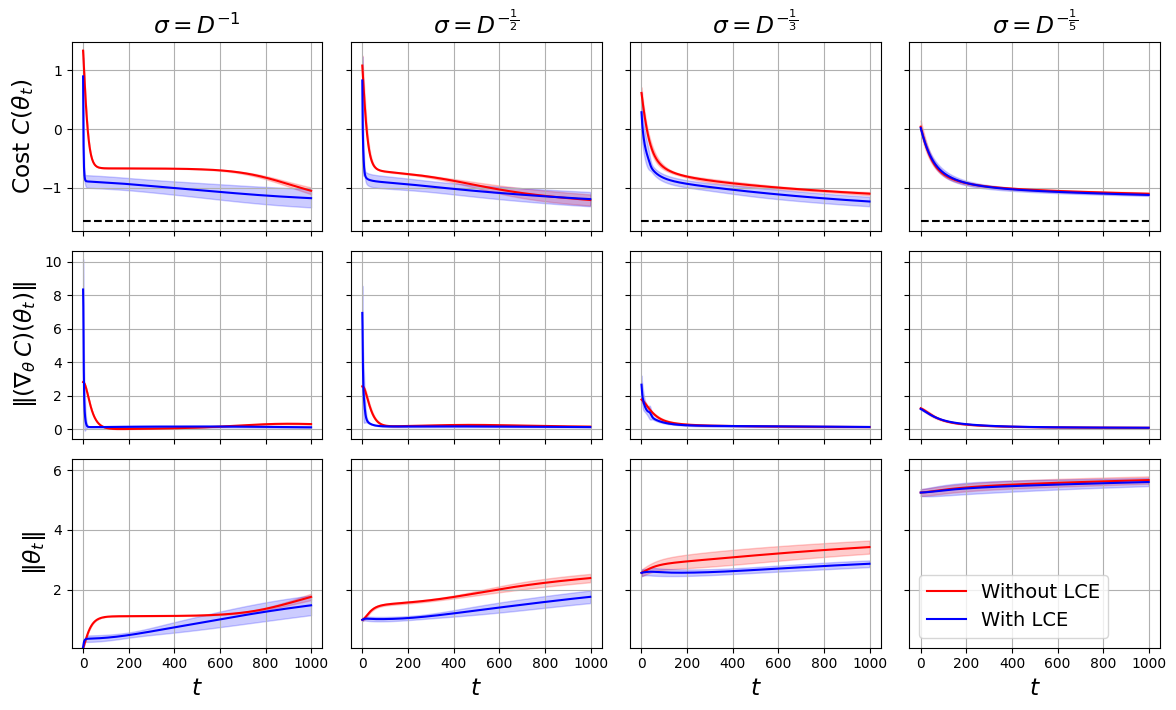

In [16]:
### Plotting the Results of EXPERIMENT IV

# load data from file
with open("data_VQE_4.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
n_qubits = data["n_qubits"]
n_layers = data["n_layers"]
number_of_runs = data["number_of_runs"]
D = data["D"]
initializations = data["initializations"]
number_of_iterations = data["number_of_iterations"]
solution = data["solution"]
#loss_data_zero = data["loss_data_zero"]
#loss_data_zero_LCE = data["loss_data_zero_LCE"]
loss_data_patch1 = data["loss_data_patch1"]
loss_data_patch1_LCE = data["loss_data_patch1_LCE"]
loss_data_patch2 = data["loss_data_patch2"]
loss_data_patch2_LCE = data["loss_data_patch2_LCE"]
loss_data_patch3 = data["loss_data_patch3"]
loss_data_patch3_LCE = data["loss_data_patch3_LCE"]
loss_data_patch4 = data["loss_data_patch4"]
loss_data_patch4_LCE = data["loss_data_patch4_LCE"]
#loss_data_global = data["loss_data_global"]
#loss_data_global_LCE = data["loss_data_global_LCE"]
#parameter_data_zero = data["parameter_data_zero"]
#parameter_data_zero_LCE = data["parameter_data_zero_LCE"]
parameter_data_patch1 = data["parameter_data_patch1"]
parameter_data_patch1_LCE = data["parameter_data_patch1_LCE"]
parameter_data_patch2 = data["parameter_data_patch2"]
parameter_data_patch2_LCE = data["parameter_data_patch2_LCE"]
parameter_data_patch3 = data["parameter_data_patch3"]
parameter_data_patch3_LCE = data["parameter_data_patch3_LCE"]
parameter_data_patch4 = data["parameter_data_patch4"]
parameter_data_patch4_LCE = data["parameter_data_patch4_LCE"]
#parameter_data_global = data["parameter_data_global"]
#parameter_data_global_LCE = data["parameter_data_global_LCE"]
#gradient_data_zero = data["gradient_data_zero"]
#gradient_data_zero_LCE = data["gradient_data_zero_LCE"]
gradient_data_patch1 = data["gradient_data_patch1"]
gradient_data_patch1_LCE = data["gradient_data_patch1_LCE"]
gradient_data_patch2 = data["gradient_data_patch2"]
gradient_data_patch2_LCE = data["gradient_data_patch2_LCE"]
gradient_data_patch3 = data["gradient_data_patch3"]
gradient_data_patch3_LCE = data["gradient_data_patch3_LCE"]
gradient_data_patch4 = data["gradient_data_patch4"]
gradient_data_patch4_LCE = data["gradient_data_patch4_LCE"]
#gradient_data_global = data["gradient_data_global"]
#gradient_data_global_LCE = data["gradient_data_global_LCE"]

# Convert to numpy array for processing (loss data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_loss_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_loss_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"loss_data_{key}")):
        padded_loss_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"loss_data_{key}_LCE")):
        padded_loss_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (loss data)
avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss = {key: np.nanstd(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (parameter data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_parameter_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_parameter_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"parameter_data_{key}")):
        padded_parameter_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"parameter_data_{key}_LCE")):
        padded_parameter_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (parameter data)
avg_norm = {key: np.nanmean(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm = {key: np.nanstd(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_norm_LCE = {key: np.nanmean(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm_LCE = {key: np.nanstd(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (gradient data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_gradient_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_gradient_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"gradient_data_{key}")):
        padded_gradient_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"gradient_data_{key}_LCE")):
        padded_gradient_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (gradient data)
avg_gradient = {key: np.nanmean(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient = {key: np.nanstd(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_gradient_LCE = {key: np.nanmean(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient_LCE = {key: np.nanstd(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)
min_norm = min(min(avg_norm[key] - std_norm[key]) for key in initializations)
max_norm = max(max(avg_norm[key] + std_norm[key]) for key in initializations)
min_gradient_norm = max(max(avg_gradient_LCE[key] + std_gradient_LCE[key]) for key in initializations)
max_gradient_norm = min(min(avg_gradient_LCE[key] - std_gradient_LCE[key]) for key in initializations)

plot_titles = {
        "patch1": r"$\sigma = D^{-1}$",
        "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
        "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
        "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
    }

# Plot all six in two rows
fig, axes = plt.subplots(3, 4, figsize=(0.4*30, 0.4*18), sharex=True, sharey='row')
font_size = 14

for idx, key in enumerate(initializations):
    # Loss plots (First row)
    axes[0, idx].plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
    axes[0, idx].plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
    axes[0, idx].plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
    #axes[0, idx].set_title(f"{key} Initialization")
    axes[0, idx].set_title(plot_titles[key], fontsize=font_size * 1.2)
    #axes[0, idx].legend(fontsize=font_size * 1)
    axes[0, idx].grid()
    axes[0, idx].set_ylim(1.1 * solution, 1.1 * max_loss)

    # Gradient norm plots (Second row)
    axes[1, idx].plot(range(number_of_iterations), avg_gradient[key], label="Without LCE", color='r')
    axes[1, idx].plot(range(number_of_iterations), avg_gradient_LCE[key], label="With LCE", color='b')
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient[key] - std_gradient[key], avg_gradient[key] + std_gradient[key], color='r', alpha=0.2)
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient_LCE[key] - std_gradient_LCE[key], avg_gradient_LCE[key] + std_gradient_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_gradient_norm, max_gradient_norm)
    
    # Parameter norm plots (Third row)
    axes[2, idx].plot(range(number_of_iterations), avg_norm[key], label="Without LCE", color='r')
    axes[2, idx].plot(range(number_of_iterations), avg_norm_LCE[key], label="With LCE", color='b')
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm[key] - std_norm[key], avg_norm[key] + std_norm[key], color='r', alpha=0.2)
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm_LCE[key] - std_norm_LCE[key], avg_norm_LCE[key] + std_norm_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_norm, 1.1*max_norm)
    
    if idx == 0:
        axes[0, idx].set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size * 1.2)
        axes[1, idx].set_ylabel(r"$\|(\nabla_\theta\,C)(\theta_t)\|$", fontsize=font_size * 1.2)
        axes[2, idx].set_ylabel(r"$\|\theta_t\|$", fontsize=font_size * 1.2)
    axes[2, idx].set_xlabel(r"$t$", fontsize=font_size * 1.2)
    axes[1, idx].grid()
    axes[2, idx].grid()

axes[-1, -1].legend(fontsize=font_size * 1)

#plt.suptitle("Heisenberg VQE Optimization with GD", fontsize=font_size * 1.5)
plt.tight_layout()
plt.savefig("VQE-experiment-biased-Heisenberg.pdf", format="pdf")
plt.show()

In [ ]:
### EXPERIMENT IV_shallow: VQE Optimization of the Biased Average Heisenberg Model with GD

# Set global variables
n_qubits = 12
n_layers = 6

ansatz, D = create_mHEA(n_qubits, n_layers)  # create PQC ansatz
observable = create_H_biased_Heisenberg(n_qubits) # create observable
J = [n_qubits*'X', n_qubits*'Y', n_qubits*'Z'] # the Hamiltonian bias to sample the LCE from
print('J:', J)

# Optimization settings
Optimizer = VanillaGradientDescent
learning_rate = 0.01 # 0.01
number_of_iterations = 1000 # 1000
number_of_runs = 5 # 5

# Data storage
loss_data_patch1 = []
loss_data_patch1_LCE = []
loss_data_patch2 = []
loss_data_patch2_LCE = []
loss_data_patch3 = []
loss_data_patch3_LCE = []
loss_data_patch4 = []
loss_data_patch4_LCE = []

parameter_data_patch1 = []
parameter_data_patch1_LCE = []
parameter_data_patch2 = []
parameter_data_patch2_LCE = []
parameter_data_patch3 = []
parameter_data_patch3_LCE = []
parameter_data_patch4 = []
parameter_data_patch4_LCE = []

gradient_data_patch1 = []
gradient_data_patch1_LCE = []
gradient_data_patch2 = []
gradient_data_patch2_LCE = []
gradient_data_patch3 = []
gradient_data_patch3_LCE = []
gradient_data_patch4 = []
gradient_data_patch4_LCE = []

for run in range(number_of_runs):
    print('run:', run)
    np.random.seed(run + 7)  # Set seed for NumPy
    random.seed(run + 7)  # Set seed for Python random

    initializations = {
        "patch1": np.random.normal(0, D**(-1), D),
        "patch2": np.random.normal(0, D**(-1/2), D),
        "patch3": np.random.normal(0, D**(-1/3), D),
        "patch4": np.random.normal(0, D**(-1/5), D),
    }

    for key, theta in initializations.items():
        theta_values, loss_values, gradient_values = Optimizer(ansatz, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}").append(loss_values)
        eval(f"parameter_data_{key}").append([np.linalg.norm(x) for x in theta_values])
        eval(f"gradient_data_{key}").append([np.linalg.norm(x) for x in gradient_values])

        # Set a new random seed for LCE transformation
        np.random.seed(run + 7)
        random.seed(run + 7)
        J0 = str(random.choice(J))
        print(J0)
        ansatz_LCE = LinearCliffordEncoder(ansatz, J0, random.randint(0, D - 1)) # sample LCE construction
        
        theta_values_LCE, loss_values_LCE, gradient_values_LCE = Optimizer(ansatz_LCE, observable, theta, learning_rate, number_of_iterations)
        eval(f"loss_data_{key}_LCE").append(loss_values_LCE)
        eval(f"parameter_data_{key}_LCE").append([np.linalg.norm(x) for x in theta_values_LCE])
        eval(f"gradient_data_{key}_LCE").append([np.linalg.norm(x) for x in gradient_values_LCE])

# Compute target energy
solution = smallest_eigenvalue(observable)

# Store data in a dictionary
data_VQE_4_shallow = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "number_of_runs": number_of_runs,
    "D": D,
    "initializations": initializations,
    "number_of_iterations": number_of_iterations,
    "solution": solution,
    "loss_data_patch1": loss_data_patch1,
    "loss_data_patch1_LCE": loss_data_patch1_LCE,
    "loss_data_patch2": loss_data_patch2,
    "loss_data_patch2_LCE": loss_data_patch2_LCE,
    "loss_data_patch3": loss_data_patch3,
    "loss_data_patch3_LCE": loss_data_patch3_LCE,
    "loss_data_patch4": loss_data_patch4,
    "loss_data_patch4_LCE": loss_data_patch4_LCE,
    "parameter_data_patch1": parameter_data_patch1,
    "parameter_data_patch1_LCE": parameter_data_patch1_LCE,
    "parameter_data_patch2": parameter_data_patch2,
    "parameter_data_patch2_LCE": parameter_data_patch2_LCE,
    "parameter_data_patch3": parameter_data_patch3,
    "parameter_data_patch3_LCE": parameter_data_patch3_LCE,
    "parameter_data_patch4": parameter_data_patch4,
    "parameter_data_patch4_LCE": parameter_data_patch4_LCE,
    "gradient_data_patch1": gradient_data_patch1,
    "gradient_data_patch1_LCE": gradient_data_patch1_LCE,
    "gradient_data_patch2": gradient_data_patch2,
    "gradient_data_patch2_LCE": gradient_data_patch2_LCE,
    "gradient_data_patch3": gradient_data_patch3,
    "gradient_data_patch3_LCE": gradient_data_patch3_LCE,
    "gradient_data_patch4": gradient_data_patch4,
    "gradient_data_patch4_LCE": gradient_data_patch4_LCE,
}

# Save data in a file
with open("data_VQE_4_shallow.pkl", "wb") as f:
    pickle.dump(data_VQE_4_shallow, f)


In [ ]:
### Plotting the Results of EXPERIMENT IV

# load data from file
with open("data_VQE_4_shallow.pkl", "rb") as f:
    data = pickle.load(f)

# Extract variables
n_qubits = data["n_qubits"]
n_layers = data["n_layers"]
number_of_runs = data["number_of_runs"]
D = data["D"]
initializations = data["initializations"]
number_of_iterations = data["number_of_iterations"]
solution = data["solution"]
#loss_data_zero = data["loss_data_zero"]
#loss_data_zero_LCE = data["loss_data_zero_LCE"]
loss_data_patch1 = data["loss_data_patch1"]
loss_data_patch1_LCE = data["loss_data_patch1_LCE"]
loss_data_patch2 = data["loss_data_patch2"]
loss_data_patch2_LCE = data["loss_data_patch2_LCE"]
loss_data_patch3 = data["loss_data_patch3"]
loss_data_patch3_LCE = data["loss_data_patch3_LCE"]
loss_data_patch4 = data["loss_data_patch4"]
loss_data_patch4_LCE = data["loss_data_patch4_LCE"]
#loss_data_global = data["loss_data_global"]
#loss_data_global_LCE = data["loss_data_global_LCE"]
#parameter_data_zero = data["parameter_data_zero"]
#parameter_data_zero_LCE = data["parameter_data_zero_LCE"]
parameter_data_patch1 = data["parameter_data_patch1"]
parameter_data_patch1_LCE = data["parameter_data_patch1_LCE"]
parameter_data_patch2 = data["parameter_data_patch2"]
parameter_data_patch2_LCE = data["parameter_data_patch2_LCE"]
parameter_data_patch3 = data["parameter_data_patch3"]
parameter_data_patch3_LCE = data["parameter_data_patch3_LCE"]
parameter_data_patch4 = data["parameter_data_patch4"]
parameter_data_patch4_LCE = data["parameter_data_patch4_LCE"]
#parameter_data_global = data["parameter_data_global"]
#parameter_data_global_LCE = data["parameter_data_global_LCE"]
#gradient_data_zero = data["gradient_data_zero"]
#gradient_data_zero_LCE = data["gradient_data_zero_LCE"]
gradient_data_patch1 = data["gradient_data_patch1"]
gradient_data_patch1_LCE = data["gradient_data_patch1_LCE"]
gradient_data_patch2 = data["gradient_data_patch2"]
gradient_data_patch2_LCE = data["gradient_data_patch2_LCE"]
gradient_data_patch3 = data["gradient_data_patch3"]
gradient_data_patch3_LCE = data["gradient_data_patch3_LCE"]
gradient_data_patch4 = data["gradient_data_patch4"]
gradient_data_patch4_LCE = data["gradient_data_patch4_LCE"]
#gradient_data_global = data["gradient_data_global"]
#gradient_data_global_LCE = data["gradient_data_global_LCE"]

# Convert to numpy array for processing (loss data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_loss_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_loss_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"loss_data_{key}")):
        padded_loss_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"loss_data_{key}_LCE")):
        padded_loss_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (loss data)
avg_loss = {key: np.nanmean(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss = {key: np.nanstd(padded_loss_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_loss_LCE = {key: np.nanmean(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_loss_LCE = {key: np.nanstd(padded_loss_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (parameter data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_parameter_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_parameter_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"parameter_data_{key}")):
        padded_parameter_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"parameter_data_{key}_LCE")):
        padded_parameter_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (parameter data)
avg_norm = {key: np.nanmean(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm = {key: np.nanstd(padded_parameter_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_norm_LCE = {key: np.nanmean(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_norm_LCE = {key: np.nanstd(padded_parameter_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

# Convert to numpy array for parameter norm processing (gradient data)
max_iters = max(max(len(run) for run in eval(f"loss_data_{key}")) for key in initializations)

padded_gradient_data = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}
padded_gradient_data_LCE = {key: np.full((number_of_runs, max_iters), np.nan) for key in initializations}

for key in initializations:
    for i, run in enumerate(eval(f"gradient_data_{key}")):
        padded_gradient_data[key][i, :len(run)] = run
    for i, run in enumerate(eval(f"gradient_data_{key}_LCE")):
        padded_gradient_data_LCE[key][i, :len(run)] = run

# Compute mean and standard deviation, ignoring NaNs (gradient data)
avg_gradient = {key: np.nanmean(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient = {key: np.nanstd(padded_gradient_data[key], axis=0)[:number_of_iterations] for key in initializations}
avg_gradient_LCE = {key: np.nanmean(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}
std_gradient_LCE = {key: np.nanstd(padded_gradient_data_LCE[key], axis=0)[:number_of_iterations] for key in initializations}

max_loss = max(max(avg_loss[key] + std_loss[key]) for key in initializations)
min_norm = min(min(avg_norm[key] - std_norm[key]) for key in initializations)
max_norm = max(max(avg_norm[key] + std_norm[key]) for key in initializations)
min_gradient_norm = max(max(avg_gradient_LCE[key] + std_gradient_LCE[key]) for key in initializations)
max_gradient_norm = min(min(avg_gradient_LCE[key] - std_gradient_LCE[key]) for key in initializations)

plot_titles = {
        "patch1": r"$\sigma = D^{-1}$",
        "patch2": r"$\sigma = D^{-\frac{1}{2}}$",
        "patch3": r"$\sigma = D^{-\frac{1}{3}}$",
        "patch4": r"$\sigma = D^{-\frac{1}{5}}$",
    }

# Plot all six in two rows
fig, axes = plt.subplots(3, 4, figsize=(0.4*30, 0.4*18), sharex=True, sharey='row')
font_size = 14

for idx, key in enumerate(initializations):
    # Loss plots (First row)
    axes[0, idx].plot(range(number_of_iterations), avg_loss[key], label="Without LCE", color='r')
    axes[0, idx].plot(range(number_of_iterations), avg_loss_LCE[key], label="With LCE", color='b')
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss[key] - std_loss[key], avg_loss[key] + std_loss[key], color='r', alpha=0.2)
    axes[0, idx].fill_between(range(number_of_iterations), avg_loss_LCE[key] - std_loss_LCE[key], avg_loss_LCE[key] + std_loss_LCE[key], color='b', alpha=0.2)
    axes[0, idx].plot(range(number_of_iterations), solution * np.ones(number_of_iterations), label="solution", color='black', linestyle='--')
    #axes[0, idx].set_title(f"{key} Initialization")
    axes[0, idx].set_title(plot_titles[key], fontsize=font_size * 1.2)
    #axes[0, idx].legend(fontsize=font_size * 1)
    axes[0, idx].grid()
    axes[0, idx].set_ylim(1.1 * solution, 1.1 * max_loss)

    # Gradient norm plots (Second row)
    axes[1, idx].plot(range(number_of_iterations), avg_gradient[key], label="Without LCE", color='r')
    axes[1, idx].plot(range(number_of_iterations), avg_gradient_LCE[key], label="With LCE", color='b')
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient[key] - std_gradient[key], avg_gradient[key] + std_gradient[key], color='r', alpha=0.2)
    axes[1, idx].fill_between(range(number_of_iterations), avg_gradient_LCE[key] - std_gradient_LCE[key], avg_gradient_LCE[key] + std_gradient_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_gradient_norm, max_gradient_norm)
    
    # Parameter norm plots (Third row)
    axes[2, idx].plot(range(number_of_iterations), avg_norm[key], label="Without LCE", color='r')
    axes[2, idx].plot(range(number_of_iterations), avg_norm_LCE[key], label="With LCE", color='b')
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm[key] - std_norm[key], avg_norm[key] + std_norm[key], color='r', alpha=0.2)
    axes[2, idx].fill_between(range(number_of_iterations), avg_norm_LCE[key] - std_norm_LCE[key], avg_norm_LCE[key] + std_norm_LCE[key], color='b', alpha=0.2)
    axes[2, idx].set_ylim(min_norm, 1.1*max_norm)
    
    if idx == 0:
        axes[0, idx].set_ylabel(r"Cost $C(\theta_t)$", fontsize=font_size * 1.2)
        axes[1, idx].set_ylabel(r"$\|(\nabla_\theta\,C)(\theta_t)\|$", fontsize=font_size * 1.2)
        axes[2, idx].set_ylabel(r"$\|\theta_t\|$", fontsize=font_size * 1.2)
    axes[2, idx].set_xlabel(r"$t$", fontsize=font_size * 1.2)
    axes[1, idx].grid()
    axes[2, idx].grid()

axes[-1, -1].legend(fontsize=font_size * 1)

#plt.suptitle("Heisenberg VQE Optimization with GD", fontsize=font_size * 1.5)
plt.tight_layout()
plt.savefig("VQE-experiment-biased-Heisenberg_shallow.pdf", format="pdf")
plt.show()